In [1]:
import torch
import numpy as np
import pandas as pd
import os
from torchvision import models, transforms
import cv2
import matplotlib.image as mpimg
from PIL import Image
from torch import nn
import tqdm

In [2]:
#os.path.exists('data/all_images/5e55a83c75d14b7257d1aceb.jpg')
sample_image = '../what-is-a-png-file-15-transparent.png'
im = cv2.imread(sample_image, cv2.IMREAD_UNCHANGED)
im.shape

(2710, 3247, 4)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def get_image(image_path):
    img = cv2.imread(image_path)    
    if len(img.shape) > 2 and img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    
    img = transformer(img).float()
    img = img.unsqueeze_(0)
    
    if device == 'cuda':
        img = img.to(device)
        
    return img
    


transformer = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

image_path = 'data/all_images'

len(os.listdir(image_path))

print(get_image(sample_image).shape)

torch.Size([1, 3, 224, 224])


In [4]:
original_model = models.resnet50(pretrained=True)
print('original_model')
print(original_model)


model = nn.Sequential(*list(original_model.children())[:-1])
print('model removed FC')
print(model)
print(model(get_image(sample_image)).shape)

original_model
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 

torch.Size([1, 2048, 1, 1])


In [5]:
for param in model.parameters():
    param.requires_grad = False
    

print(model(get_image(sample_image)).view(1, -1).shape)    

torch.Size([1, 2048])


In [6]:
if device == 'cuda':
    model.to(device)

image_features = []    
for i in tqdm.tqdm(os.listdir(image_path)):
    img = get_image(os.path.join(image_path, i))
    pred = model(img)
    pred = pred.view(1, -1)
    image_features.append(pred.detach().cpu().numpy())

    

    

 72%|███████▏  | 5667/7851 [25:03<09:17,  3.92it/s]

AttributeError: 'NoneType' object has no attribute 'shape'

In [16]:
image_features2 = np.stack(image_features).reshape((-1, 2048))

In [19]:
image_features2.shape

(5667, 2048)

In [18]:
from sklearn.decomposition import PCA

In [20]:
pca = PCA(2)

In [21]:
projected = pca.fit_transform(image_features2)
print(image_features2.shape)
print(projected.shape)

(5667, 2048)
(5667, 2)


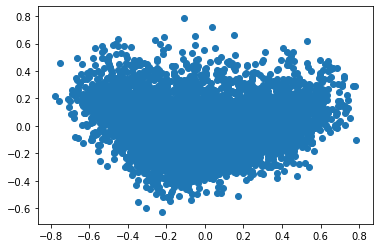

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(projected[:, 0], projected[:, 1])